In [3]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
import upsetplot
from dataclasses import dataclass

from ncbi.datasets.openapi import ApiClient as DatasetsApiClient
from ncbi.datasets.openapi import ApiException as DatasetsApiException
from ncbi.datasets import GeneApi as DatasetsGeneApi
from ncbi.datasets.openapi.models import V1GeneMatch

In [4]:
os.chdir("/projects/ly_vu_direct_rna/MetaCompore")

In [5]:
%matplotlib inline
mpl.rc_file_defaults()
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [6]:
valid_refs_path = Path("results/alignment/min_ref_coverage/annotated_valid_references_list.txt")
valid_refs = valid_refs_path.read_text()
print(valid_refs)

ENST00000361390.2: MT-ND1
ENST00000361453.3: MT-ND2
ENST00000361624.2: MT-CO1
ENST00000361739.1: MT-CO2
ENST00000361851.1: MT-ATP8
ENST00000361899.2: MT-ATP6
ENST00000362079.2: MT-CO3
ENST00000361227.2: MT-ND3
ENST00000361335.1: MT-ND4L
ENST00000361381.2: MT-ND4
ENST00000361567.2: MT-ND5
ENST00000361681.2: MT-ND6
ENST00000361789.2: MT-CYB
ENST00000617731.2: RPS17
ENST00000633731.1: RPS17
ENST00000612465.1: 
ENST00000393394.5: 
ENST00000632163.1: RPL41P2
ENST00000359635.9: HLA-B
ENST00000613839.2: MIF
ENST00000617605.4: B2M
ENST00000457341.6: RPS18
ENST00000619718.2: LY6E
ENST00000612112.4: PRTN3
ENST00000621878.4: MRPL45
ENST00000619717.4: LAIR1
ENST00000361365.7: EIF1AY
ENST00000250784.13: RPS4Y1
ENST00000336079.8: DDX3Y
ENST00000620783.2: CISD3
ENST00000381989.4: PARP4
ENST00000382172.4: MIPEP
ENST00000341423.10: HMGB1
ENST00000379161.5: NUFIP1
ENST00000261667.8: KPNA3
ENST00000435618.6: HLA-B
ENST00000340473.8: GTF2F2
ENST00000382751.4: URB1
ENST00000399312.3: MRPS6
ENST00000314103.

In [7]:
import re
valid_refs2 = re.split(": |\s", valid_refs)

In [8]:
def Convert_dict(a):  
    init = iter(valid_refs2)  
    res_dct = dict(zip(init, init))  
    return res_dct  
         
print(Convert_dict(valid_refs2))

{'ENST00000361390.2': 'MT-ND1', 'ENST00000361453.3': 'MT-ND2', 'ENST00000361624.2': 'MT-CO1', 'ENST00000361739.1': 'MT-CO2', 'ENST00000361851.1': 'MT-ATP8', 'ENST00000361899.2': 'MT-ATP6', 'ENST00000362079.2': 'MT-CO3', 'ENST00000361227.2': 'MT-ND3', 'ENST00000361335.1': 'MT-ND4L', 'ENST00000361381.2': 'MT-ND4', 'ENST00000361567.2': 'MT-ND5', 'ENST00000361681.2': 'MT-ND6', 'ENST00000361789.2': 'MT-CYB', 'ENST00000617731.2': 'RPS17', 'ENST00000633731.1': 'RPS17', 'ENST00000612465.1': '', 'ENST00000393394.5': '', 'ENST00000632163.1': 'RPL41P2', 'ENST00000359635.9': 'HLA-B', 'ENST00000613839.2': 'MIF', 'ENST00000617605.4': 'B2M', 'ENST00000457341.6': 'RPS18', 'ENST00000619718.2': 'LY6E', 'ENST00000612112.4': 'PRTN3', 'ENST00000621878.4': 'MRPL45', 'ENST00000619717.4': 'LAIR1', 'ENST00000361365.7': 'EIF1AY', 'ENST00000250784.13': 'RPS4Y1', 'ENST00000336079.8': 'DDX3Y', 'ENST00000620783.2': 'CISD3', 'ENST00000381989.4': 'PARP4', 'ENST00000382172.4': 'MIPEP', 'ENST00000341423.10': 'HMGB1', '

In [9]:
acc2gene = Convert_dict(valid_refs2)

## Nanocompore results

In [10]:
infection = {
    "GE031_55_2C": "Bacterial", 
    "GE044_56_5D": "Bacterial and Viral", 
    "6201_8_0_P1": "Probable Viral", 
    "6679_23_0_P1": "Probable Bacterial"
}

In [11]:
frames = []
keep_cols = ["pvalue", "peak", "ref_kmer", "LOR"]
max_pval = 0.01
peaks_only = True
only_non_ribosomal = False
min_abs_lor = 0.1

gmm_tsv = f"results/final2/nanocompore_results_GMM_context_0.tsv"
gmm_df = pd.read_csv(gmm_tsv, sep="\t")
gmm_df["ref_id"] = [acc2gene[x] for x in gmm_df["ref_id"]]
gmm_df.set_index(["ref_id", "pos"], verify_integrity=True, inplace=True)

df = gmm_df.query(f"pvalue < @max_pval and (LOR>@min_abs_lor or LOR<-@min_abs_lor)")
df.reset_index(inplace=True)
ncomp_df = df

In [12]:
ncomp_df

,ref_id,pos,pvalue,peak,ref_kmer,LOR
0,MRPS35,963,4.190526e-03,True,AGACT,0.707552
1,RPL6,110,2.072422e-06,True,ACCTC,0.275206
2,RPL6,143,1.238491e-05,False,CCCAT,-0.249509
3,RPL6,158,3.387938e-06,True,ACCCT,0.208209
4,RPL6,190,7.285052e-08,True,TCCCG,-0.274712
...,...,...,...,...,...,...
1739,EIF4A3,1498,9.419981e-05,True,GGACT,-0.775231
1740,EIF4A3,1499,2.140827e-04,False,GACTT,-0.761830
1741,COX6B1,137,3.266452e-04,True,CCTTT,0.235580
1742,RPS27,88,1.870567e-04,True,ACACA,0.166282


In [13]:
ncomp_df.groupby(["ref_id"]).count()

,pos,pvalue,peak,ref_kmer,LOR
ref_id,,,,,
,9,9,9,9,9
ACTR2,3,3,3,3,3
ACTR3,1,1,1,1,1
ADIPOR1,1,1,1,1,1
ANXA4,1,1,1,1,1
...,...,...,...,...,...
YBX1,6,6,6,6,6
YWHAQ,1,1,1,1,1
ZFP36L2,5,5,5,5,5


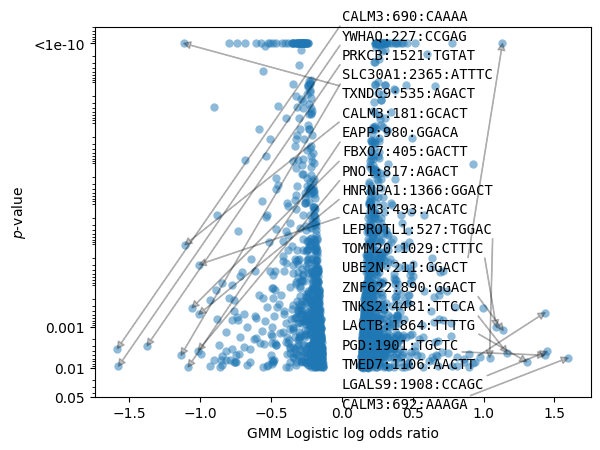

In [55]:
x = "LOR"
y = "pvalue"
# hue = "sample"
pval_cap = 1e-10  # stops axes from getting huge!
data = ncomp_df
data[y] = [max(p, pval_cap) for p in data[y]]

fig, ax = plt.subplots()
sns.scatterplot(data=data, x=x, y=y, linewidth=0, ax=ax, alpha=0.5)
# ax.set_ylim((5e-21, 0.99))
ax.invert_yaxis()
ax.set_yscale("logit")
ticks = [0.05, 0.01, 0.001, pval_cap]
ax.set_yticks(ticks)
ticks[-1] = f"<{ticks[-1]}"
ax.set_yticklabels(ticks)
ax.set_ylabel("$p$-value")
ax.set_xlabel("GMM Logistic log odds ratio")


ypos = max_pval
xpos = 0#min_abs_lor
for _, row in data.query("LOR>=1 or LOR<=-1").sort_values(x, ascending=False).iterrows():
    label = f'{row["ref_id"]}:{row["pos"]}:{row["ref_kmer"]}'
    xx = row[x]
    yy = row[y]
    kmer = row["ref_kmer"]
#     alpha = 1 if kmer == "ACAGG" else 0.15
    ax.annotate(label, 
                xy=(xx, yy), xycoords='data', 
                font="monospace",
                xytext=(xpos, ypos), textcoords='data',
                horizontalalignment="left",
                verticalalignment="top",
                arrowprops=dict( 
                    color="black", 
                    alpha=0.25, 
#                     shrink=0.1, 
                    width=0.25, 
                    headlength=5, 
                    headwidth=5,
                ))
    ypos = ypos/3

In [15]:
data.query("LOR<=-1 or LOR>=1").sort_values(by="ref_id")

,ref_id,pos,pvalue,peak,ref_kmer,LOR
481,CALM3,692,5.721224e-03,False,AAAGA,1.597090
473,CALM3,181,9.403698e-06,True,GCACT,-1.108882
477,CALM3,493,2.882095e-05,True,ACATC,-1.008590
480,CALM3,690,3.419998e-03,True,CAAAA,-1.585195
258,EAPP,980,9.704068e-03,True,GGACA,-1.085715
394,FBXO7,405,3.382415e-04,True,GACTT,-1.058947
902,HNRNPA1,1366,4.869534e-04,True,GGACT,-1.011022
325,LACTB,1864,7.180569e-03,True,TTTTG,1.304648
762,LEPROTL1,527,5.705554e-03,True,TGGAC,1.041939
553,LGALS9,1908,3.991993e-03,True,CCAGC,1.449095


## xPore results

In [169]:
frames = []
max_pval = 0.01
only_non_ribosomal = False
min_abs_diff = 0.0

xpore_tsv = f"results/xpore/xpore_diffmod/diffmod.table"
xpore_df = pd.read_csv(xpore_tsv)
xpore_df.rename(
    columns={
        "id": "ref_id",
        "position": "pos",
        "kmer": "ref_kmer",
        "diff_mod_rate_control_vs_test": "diff_mod_rate",
        "pval_control_vs_test": "pvalue",
        "z_score_control_vs_test": "zscore"
    },
    inplace=True
)
    
xpore_df["ref_id"] = [acc2gene[x] for x in xpore_df["ref_id"]]
df = xpore_df.query(f"pvalue < @max_pval and (diff_mod_rate>@min_abs_diff or diff_mod_rate<-@min_abs_diff)").copy()

xpore_df = df

In [170]:
xpore_df

,ref_id,pos,ref_kmer,diff_mod_rate,pvalue,zscore,mod_rate_control-rep1,mod_rate_control-rep2,mod_rate_test-rep1,mod_rate_test-rep2,...,coverage_control-rep2,coverage_test-rep1,coverage_test-rep2,mu_unmod,mu_mod,sigma2_unmod,sigma2_mod,conf_mu_unmod,conf_mu_mod,mod_assignment
0,NDUFAB1,249,GACGT,-0.081168,2.358812e-04,-3.677121,0.273884,0.279855,NaN,0.358038,...,659.0,NaN,983.0,76.405964,80.217732,1.590998,10.411499,0.716223,0.118246,higher
1,NDUFAB1,225,CCAGT,0.120423,2.048008e-07,5.194926,0.703200,0.718045,NaN,0.590200,...,624.0,NaN,914.0,96.727186,101.344284,30.096550,4.248754,0.889500,0.295548,higher
5,NDUFAB1,508,CCCTT,-0.167201,9.143924e-13,-7.142814,0.388486,0.500873,NaN,0.611881,...,672.0,NaN,980.0,71.775946,73.699434,1.234546,4.713206,0.610813,0.184370,higher
11,NDUFAB1,159,GCTCG,-0.116669,9.797014e-07,-4.895672,0.382500,0.439955,NaN,0.527896,...,664.0,NaN,959.0,79.296686,82.146274,2.838735,14.772655,0.664343,0.151635,higher
16,NDUFAB1,52,TATGT,-0.044927,1.642552e-03,-3.148243,0.067881,0.088200,NaN,0.122968,...,640.0,NaN,966.0,78.590428,83.139980,1.781161,20.401550,0.677476,0.447443,higher
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651361,ZBTB1,29,GAGCC,-0.503445,1.942677e-05,-4.271379,0.496492,NaN,0.999938,NaN,...,NaN,16.0,NaN,102.704927,107.114970,7.137297,14.440919,0.901160,0.181522,higher
3651392,ZBTB1,859,TGGAT,-0.403564,1.510026e-03,-3.172750,0.474939,NaN,0.757068,0.999938,...,NaN,24.0,16.0,126.648888,122.528200,2.107858,11.804016,0.640839,0.404633,lower
3651469,ZBTB1,2049,AGCGT,-0.322669,1.173555e-03,-3.245231,0.203243,NaN,0.521120,0.530703,...,NaN,54.0,29.0,112.246263,101.247931,20.555991,141.564941,0.609437,0.423706,lower
3651480,ZBTB1,1184,GAGCC,0.345693,8.715900e-04,3.328998,0.379564,NaN,0.000034,0.067709,...,NaN,29.0,20.0,103.318601,98.770989,3.592856,11.577515,0.937027,0.153630,lower


In [18]:
def symlogspace(arr, n_bins, zero_eps=0.1, padding=0):
    """
    Splits a data range into log-like bins but with 0 and negative values taken into account.
    Can be used together with matplotlib 'symlog' axis sacale (i.e. ax.set_xscale('symlog'))
    Feel free to contribute: https://gist.github.com/artoby/0bcf790cfebed5805fbbb6a9853fe5d5
    """
    a = min(arr) / (1 + padding)
    b = max(arr) * (1 + padding)
        
    if a > b:
        a, b = b, a
        
    neg_range_log = None
    if a < -zero_eps:
        neg_range_log = [np.log10(-a), np.log10(zero_eps)]
    
    # Add a value to zero bin edges in case a lies within [-zero_eps; zero_eps) - so an additional bin will be added before positive range
    zero_bin_edges = []
    if -zero_eps <= a < zero_eps:
        zero_bin_edges = [a]
            
    pos_range_log = None
    if b > zero_eps:
        pos_range_log = [np.log10(max(a, zero_eps)), np.log10(b)]

    nonzero_n_bin_edges = n_bins + 1 - len(zero_bin_edges)
    
    neg_range_log_size = (neg_range_log[0] - neg_range_log[1]) if neg_range_log is not None else 0
    pos_range_log_size = (pos_range_log[1] - pos_range_log[0]) if pos_range_log is not None else 0
    
    range_log_size = neg_range_log_size + pos_range_log_size
    pos_n_bin_edges_raw = int(round(nonzero_n_bin_edges * (pos_range_log_size/range_log_size))) if range_log_size > 0 else 0
    # Ensure each range has at least 2 edges if it's not empty
    neg_n_bin_edges = max(2, nonzero_n_bin_edges - pos_n_bin_edges_raw) if neg_range_log_size > 0 else 0
    pos_n_bin_edges = max(2, nonzero_n_bin_edges - neg_n_bin_edges) if pos_range_log_size > 0 else 0
    
    neg_bin_edges = []
    if neg_n_bin_edges > 0:
        neg_bin_edges = list(-np.logspace(neg_range_log[0], neg_range_log[1], neg_n_bin_edges))
        
    pos_bin_edges = []
    if pos_n_bin_edges > 0:
        pos_bin_edges = list(np.logspace(pos_range_log[0], pos_range_log[1], pos_n_bin_edges))
    
    result = neg_bin_edges + zero_bin_edges + pos_bin_edges
    return result

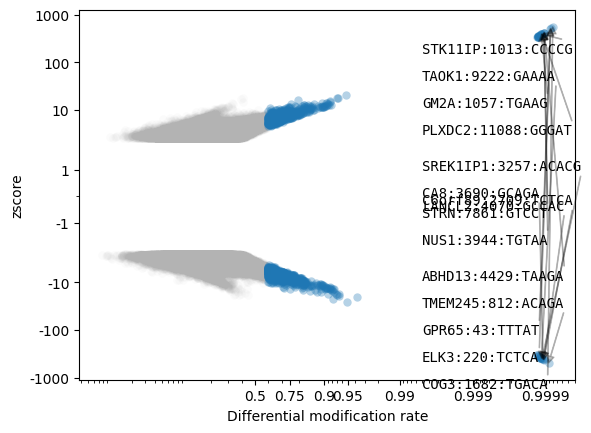

In [171]:
x = "diff_mod_rate"
y = "zscore"
# hue = "sample"

x_sig = 0.6 #0.85
data = xpore_df.copy()
data[x] = data[x].abs()  # absolute value of diff mod rate

non_sig_data = data.query(f"{x}<{x_sig}")
sig_data = data.query(f"{x}>={x_sig}")


fig, ax = plt.subplots()
sns.scatterplot(data=non_sig_data, x=x, y=y, linewidth=0, ax=ax, alpha=0.05, color="0.7")
sns.scatterplot(data=sig_data, x=x, y=y, linewidth=0, ax=ax, alpha=0.33)
ax.set_yscale("symlog")
ax.set_xscale("logit")
xticks = [0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
yticks = [-1000, -100, -10, -1, 1, 10, 100, 1000]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel("Differential modification rate")

n_annotations = 15
ypos = symlogspace(np.array(yticks), n_annotations)
xpos = 0.995
i = 0
for _, row in sig_data.nlargest(n_annotations, x).iterrows():
    label = f'{row["ref_id"]}:{row["pos"]}:{row["ref_kmer"]}'
    xx = row[x]
    yy = row[y]
    kmer = row["ref_kmer"]
    ax.annotate(label, 
                xy=(xx, yy), xycoords='data', 
                font="monospace",
                xytext=(xpos, ypos[i]), textcoords='data',
                horizontalalignment="left",
                verticalalignment="top",
                arrowprops=dict( 
                    color="black", 
                    alpha=0.25, 
                    width=0.25, 
                    headlength=5, 
                    headwidth=5,
                ))
    i += 1

In [172]:
sig_data

,ref_id,pos,ref_kmer,diff_mod_rate,pvalue,zscore,mod_rate_control-rep1,mod_rate_control-rep2,mod_rate_test-rep1,mod_rate_test-rep2,...,coverage_control-rep2,coverage_test-rep1,coverage_test-rep2,mu_unmod,mu_mod,sigma2_unmod,sigma2_mod,conf_mu_unmod,conf_mu_mod,mod_assignment
2338,DVL2,661,CTTCC,0.617731,4.741598e-10,6.227426,0.999971,NaN,0.409335,0.355146,...,NaN,29.0,20.0,74.407114,72.894161,0.833746,5.815854,0.927975,0.521846,lower
4190,RALA,24,CAGGA,0.611313,1.295070e-06,4.840509,0.716556,NaN,0.105243,NaN,...,NaN,15.0,NaN,102.134065,108.758694,12.397146,77.478970,0.632056,0.185565,higher
4452,RALA,2403,GTTAA,0.694851,1.402091e-24,-10.233599,0.354859,0.255369,0.999971,0.999960,...,30.0,34.0,25.0,83.506919,85.158848,0.895222,3.143064,0.881432,0.411834,higher
4875,RALA,967,AGCAT,0.640982,1.090879e-15,8.016176,0.505118,0.776930,0.000034,0.000050,...,19.0,29.0,20.0,113.887231,118.144780,12.696078,6.602076,0.795030,0.399113,higher
7006,ERCC1,133,GGATG,0.616943,6.073360e-09,-5.814725,NaN,0.000067,0.617010,NaN,...,15.0,21.0,NaN,125.171224,131.342377,43.224820,11.499879,0.867821,0.296669,higher
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637096,AIMP1,978,GCTCA,0.667539,8.430867e-11,-6.492705,0.324580,0.340225,NaN,0.999941,...,15.0,NaN,17.0,76.419169,79.317859,1.274030,7.335303,0.846744,0.410047,higher
3639868,SPN,5377,TAGCC,0.788159,6.730030e-27,-10.738261,0.000045,NaN,0.788205,NaN,...,NaN,31.0,NaN,99.693156,103.963522,13.213379,5.414332,0.624827,0.354962,higher
3650590,ZBTB1,3342,GGTTG,0.722655,1.875376e-16,-8.229793,0.000053,NaN,0.722707,NaN,...,NaN,26.0,NaN,113.364470,97.571799,98.530872,59.499096,0.647523,0.098678,lower
3650695,ZBTB1,3495,CACAG,0.657442,4.182810e-09,-5.876797,0.000067,NaN,0.559324,0.755693,...,NaN,21.0,15.0,80.235871,84.706415,20.176216,5.828349,0.707280,0.302860,higher


In [173]:
sig_data.groupby(["ref_id"]).count()

,pos,ref_kmer,diff_mod_rate,pvalue,zscore,mod_rate_control-rep1,mod_rate_control-rep2,mod_rate_test-rep1,mod_rate_test-rep2,coverage_control-rep1,coverage_control-rep2,coverage_test-rep1,coverage_test-rep2,mu_unmod,mu_mod,sigma2_unmod,sigma2_mod,conf_mu_unmod,conf_mu_mod,mod_assignment
ref_id,,,,,,,,,,,,,,,,,,,,
AARS2,2,2,2,2,2,2,2,2,0,2,2,2,0,2,2,2,2,2,2,2
ABHD13,5,5,5,5,5,5,0,1,4,5,0,1,4,5,5,5,5,5,5,5
ABI1,3,3,3,3,3,3,0,3,0,3,0,3,0,3,3,3,3,3,3,3
ABT1,2,2,2,2,2,2,0,2,0,2,0,2,0,2,2,2,2,2,2,2
ACADSB,3,3,3,3,3,3,2,3,1,3,2,3,1,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF516,2,2,2,2,2,2,0,2,0,2,0,2,0,2,2,2,2,2,2,2
ZNF706,4,4,4,4,4,4,0,4,2,4,0,4,2,4,4,4,4,4,4,4
ZNF740,3,3,3,3,3,3,0,3,1,3,0,3,1,3,3,3,3,3,3,3


## Overlapping significant positions

In [22]:
import networkx as nx
from itertools import combinations
from typing import Optional

In [111]:
D = 2

@dataclass(frozen=True)
class Position:
    gene: str
    pos: int
    # sample: str
    tool: str
        
    def distance(self, other: "Position") -> Optional[int]:
        if self.gene != other.gene:
            return None
        return abs(self.pos - other.pos)

In [174]:
xpore_sig_pos = set([Position(*t, "xpore") for t in zip(sig_data["ref_id"], sig_data["pos"])])

In [175]:
xpore_sig_pos

{Position(gene='USP24', pos=4962, tool='xpore'),
 Position(gene='ACADSB', pos=1456, tool='xpore'),
 Position(gene='SLC25A10', pos=656, tool='xpore'),
 Position(gene='PTGR3', pos=2976, tool='xpore'),
 Position(gene='TAOK1', pos=10001, tool='xpore'),
 Position(gene='APPL1', pos=702, tool='xpore'),
 Position(gene='CHCHD7', pos=517, tool='xpore'),
 Position(gene='ZFP91', pos=662, tool='xpore'),
 Position(gene='STK11IP', pos=498, tool='xpore'),
 Position(gene='NSUN5', pos=808, tool='xpore'),
 Position(gene='WDR33', pos=1963, tool='xpore'),
 Position(gene='UFL1', pos=1999, tool='xpore'),
 Position(gene='TRMT5', pos=17, tool='xpore'),
 Position(gene='TMX4', pos=2285, tool='xpore'),
 Position(gene='RAB3GAP2', pos=4227, tool='xpore'),
 Position(gene='DOT1L', pos=3062, tool='xpore'),
 Position(gene='SPPL2A', pos=4003, tool='xpore'),
 Position(gene='AGO2', pos=9911, tool='xpore'),
 Position(gene='CDC42EP3', pos=3493, tool='xpore'),
 Position(gene='IGF2BP1', pos=311, tool='xpore'),
 Position(gene=

In [176]:
len(xpore_sig_pos)

1368

In [177]:
ncomp_sig_pos = set([Position(*t, "nanocompore") for t in zip(ncomp_df["ref_id"], ncomp_df["pos"])])

In [178]:
len(ncomp_sig_pos)

1744

In [179]:
all_sig_pos = ncomp_sig_pos.union(xpore_sig_pos)

In [180]:
len(all_sig_pos)

3112

In [214]:
all_sig_pos

{Position(gene='MT-CO2', pos=203, tool='nanocompore'),
 Position(gene='RPS16', pos=362, tool='nanocompore'),
 Position(gene='USP24', pos=4962, tool='xpore'),
 Position(gene='NA', pos=168, tool='nanocompore'),
 Position(gene='OAZ1', pos=235, tool='nanocompore'),
 Position(gene='ACADSB', pos=1456, tool='xpore'),
 Position(gene='SLC25A10', pos=656, tool='xpore'),
 Position(gene='RPS3', pos=750, tool='nanocompore'),
 Position(gene='PTGR3', pos=2976, tool='xpore'),
 Position(gene='TAOK1', pos=10001, tool='xpore'),
 Position(gene='RPS12', pos=322, tool='nanocompore'),
 Position(gene='RPL29', pos=154, tool='nanocompore'),
 Position(gene='APPL1', pos=702, tool='xpore'),
 Position(gene='CHCHD7', pos=517, tool='xpore'),
 Position(gene='ZFP91', pos=662, tool='xpore'),
 Position(gene='STK11IP', pos=498, tool='xpore'),
 Position(gene='OAZ1', pos=52, tool='nanocompore'),
 Position(gene='NSUN5', pos=808, tool='xpore'),
 Position(gene='SLC25A6', pos=957, tool='nanocompore'),
 Position(gene='WDR33', po

In [197]:
G = nx.Graph()

In [198]:
for u, v in combinations(all_sig_pos, r=2):
    d = u.distance(v)
    if d is None or d > D:
        continue
    G.add_edge(u, v, weight=d)

In [199]:
len(G.nodes)

364

In [200]:
len(G.edges)

202

In [201]:
print(G)

Graph with 364 nodes and 202 edges


The number of overlapping positions

In [186]:
nx.number_connected_components(G)

170

In [202]:
CC = list(nx.connected_components(G))
largest_cc = max(CC, key=len)

In [203]:
CC

[{Position(gene='NA', pos=167, tool='nanocompore'),
  Position(gene='NA', pos=168, tool='nanocompore')},
 {Position(gene='OAZ1', pos=233, tool='nanocompore'),
  Position(gene='OAZ1', pos=235, tool='nanocompore')},
 {Position(gene='RPS3', pos=748, tool='nanocompore'),
  Position(gene='RPS3', pos=750, tool='nanocompore')},
 {Position(gene='FTL', pos=814, tool='nanocompore'),
  Position(gene='FTL', pos=815, tool='nanocompore')},
 {Position(gene='RPS14', pos=133, tool='nanocompore'),
  Position(gene='RPS14', pos=135, tool='nanocompore')},
 {Position(gene='EEF2', pos=2094, tool='nanocompore'),
  Position(gene='EEF2', pos=2096, tool='nanocompore')},
 {Position(gene='HSPE1', pos=445, tool='nanocompore'),
  Position(gene='HSPE1', pos=446, tool='nanocompore')},
 {Position(gene='RPL10A', pos=598, tool='nanocompore'),
  Position(gene='RPL10A', pos=599, tool='nanocompore')},
 {Position(gene='RPL7', pos=637, tool='nanocompore'),
  Position(gene='RPL7', pos=638, tool='nanocompore'),
  Position(gene=

In [204]:
len(largest_cc)

5

In [206]:
largest_cc

{Position(gene='PGAM1', pos=1727, tool='nanocompore'),
 Position(gene='PGAM1', pos=1728, tool='nanocompore'),
 Position(gene='PGAM1', pos=1730, tool='nanocompore'),
 Position(gene='PGAM1', pos=1731, tool='nanocompore'),
 Position(gene='PGAM1', pos=1733, tool='nanocompore')}

In [207]:
from collections import Counter
cc_sizes = Counter([len(c) for c in CC])
for d in sorted(cc_sizes):
    print(d, cc_sizes[d])

2 151
3 15
4 3
5 1


Remove CCs where all members are from the same sample and tool

In [152]:
for c in CC:
    s = {(u.gene, u.tool) for u in c}
    if len(s) == 1:
        G.remove_nodes_from(c)

In [194]:
len(G.nodes)

364

In [215]:
len(G.edges)

202

In [208]:
nx.number_connected_components(G)

170

So we only lost 2 positions from that filtering

In [107]:
CC = list(nx.connected_components(G))
cc_sizes = Counter([len(c) for c in CC])
for d in sorted(cc_sizes):
    print(d, cc_sizes[d])

2 151
3 15
4 3
5 1


In [216]:
H = G.copy()
# for c in CC:
#     tools = {u.tool for u in c}
#     if len(tools) == 1:
#         H.remove_nodes_from(c)

In [217]:
H_cc = list(nx.connected_components(H))

In [218]:
print(f"{len(H_cc)} CCs with both tools")

170 CCs with both tools


In [219]:
# add "dummy" edges between all members of CCs so we can remove excess nodes without losing connections
for c in nx.connected_components(H):
    for u, v in combinations(c, 2):
        H.add_edge(u, v, weight=0)

# remove sample-tool duplicates from clusters
nodes_to_remove = set()
for c in nx.connected_components(H):
    seen = set()
    for v in c:
        k = (v.tool, v.gene)
        if k in seen:
            nodes_to_remove.add(v)
        else:
            seen.add(k)

In [220]:
H.remove_nodes_from(nodes_to_remove)

In [221]:
def node_label(p: Position) -> str:
    return f"{p.gene}:{p.pos}"

In [224]:
print(H)

Graph with 170 nodes and 0 edges


AttributeError: 'Position' object has no attribute 'sample'

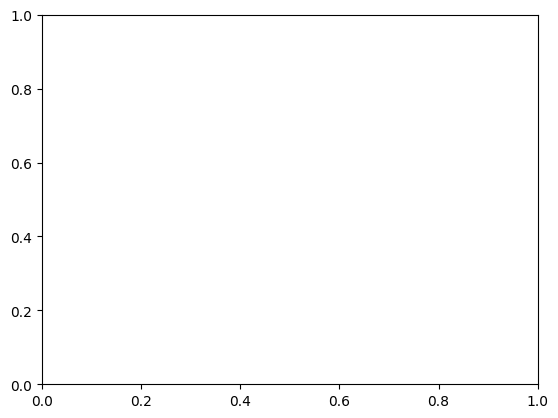

In [222]:
H_cc = list(nx.connected_components(H))
fig, ax = plt.subplots()

graph_layout = nx.multipartite_layout
black = "#2e3440"
node_colour_key = "node_colour"
label_key = "label"
align = "horizontal"
edge_colour = black
node_size = 50
edge_width = 1
font_size = 8
fw = "normal"
fc = black
subset_key = "cluster_id"

shapes = {"xpore": "o", "nanocompore": "s"}
sample_colours = {s: colours[i] for i, s in enumerate(infection)}
node_colours = {v: sample_colours[v.sample] for v in H.nodes}
# node_labels = {v: node_label(v) for v in H.nodes}

nx.set_node_attributes(H, node_colours, node_colour_key)
# nx.set_node_attributes(H, node_labels, label_key)

# add labeling of CCs for multipartite layout
cluster_ids = dict()
for i, cc in enumerate(H_cc):
    for v in cc:
        cluster_ids[v] = i
        
nx.set_node_attributes(H, cluster_ids, subset_key)

pos = graph_layout(H, subset_key=subset_key, align=align)

# sort the positions within each cluster so same samples are together
for c in H_cc:
    c_pos = {v: pos[v] for v in c}
    sorted_samples = sorted(c, key=lambda p: list(infection.keys()).index(p.sample))
    sorted_pos = sorted(list(map(list, c_pos.values())))
    for v, xy in zip(sorted_samples, sorted_pos):
        pos[v] = xy
    

for tool, shape in shapes.items():
    vs = [k for k, v in node_colours.items() if k.tool == tool]

    ps = {v: pos[v] for v in vs}
    cols = [H.nodes[v][node_colour_key] for v in vs]

    node_ax = nx.draw_networkx_nodes(
        H,
        pos=ps,
        nodelist=vs,
        node_color=cols,
        node_shape=shape,
        edgecolors=edge_colour,
        ax=ax,
        node_size=node_size,
    )

        
nx.draw_networkx_edges(H, pos, ax=ax, edge_color=edge_colour, width=edge_width)
# nx.draw_networkx_labels(
#     H, pos, ax=ax, font_size=font_size, font_weight=fw, font_color=fc, labels=node_labels, 
# )
xpos = ax.get_xlim()[0]
arrowprops=dict( 
                color="black", 
                arrowstyle="simple, head_length=0.5, head_width=0.3, tail_width=0.05",
                relpos=(1, 0.5)
                )

cluster_labels = []
for cc in map(list, H_cc):
    _, ypos = pos[cc[0]]
    min_xpos = min(pos[v][0] for v in cc)
    gene = cc[0].gene
    gene_positions = [v.pos for v in cc]
    min_pos = min(gene_positions)
    max_pos = max(gene_positions)
    if min_pos == max_pos:
        label = f"{gene}:{min_pos}"
    else:
        label = f"{gene}:{min_pos}-{max_pos}"
    cluster_labels.append(label)
    xytext = (xpos, ypos)
    xy = (min_xpos, ypos)
#     ax.text(xpos, ypos, label, fontsize=font_size)
    ax.annotate(label, xy=xy, xytext=xytext, arrowprops=arrowprops, fontsize=font_size)

ax.set_title("Overlapping modification positions")

# legend
patches = []
fakexy = (0, 0)
for k, shape in shapes.items():
    patch = plt.Line2D(fakexy, fakexy, linestyle='none', marker=shape, label=k, color=black)
    patches.append(patch)

tool_leg = plt.legend(handles=patches, title="Tools", loc="upper right")
    
patches = []
for sample, colour in sample_colours.items():
    patch = plt.Line2D(fakexy, fakexy, linestyle='none', marker="o", label=sample, color=colour)
    patches.append(patch)
    
plt.legend(handles=patches, title="Samples", loc="center right")
plt.gca().add_artist(tool_leg)

In [52]:
from collections import defaultdict
labels = defaultdict(list)
for l in sorted(cluster_labels):
    gene, pos = l.split(":")
    labels[gene].append(pos)
    
for gene, poss in labels.items():
    print(gene, sorted(poss, key=lambda s: int(s.split("-")[0])))